In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from communav.utils import db
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/tmp/ipykernel_29608/1422713605.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/retn0/repositories/nbsp1221/communav/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 카테고리 정의

CATEGORIES = {
    0: '자유',
    1: '학사',
    2: '장학 · 행정',
    3: '학교생활',
    4: '수업',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '취업 · 진로',
    9: '일상생활',
    10: '음식점 · 카페',
    11: '취미 · 여가',
    12: '인간관계',
    13: '병역'
}

In [4]:
# 파라미터 설정

MODEL_ID = 'beomi/KcELECTRA-base-v2022'
NUM_LABELS = len(CATEGORIES)
MAX_LENGTH = 128
F_BETA = 0.5
METRIC_AVERAGE = 'weighted'
METRIC_ZERO_DIVISION = 0
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 2e-5
SAVE_PATH = '.'

In [5]:
# 커뮤니티 게시글 데이터 로드

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute('''
    SELECT id, title, text, category_id
    FROM everytime_article_dataset
    WHERE category_id IS NOT NULL
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 15213 articles.


In [6]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': 21479637, 'title': '어제 비마관 화장실에서 핸드폰 찾아주신분!', 'text': '제가 경황이 없어서 감사하다고도 못 했네요.\n정말 감사합니다!!!', 'category_id': 9}
{'id': 21480514, 'title': '클럽좋아하시는분 계세요~?', 'text': '남자 신입생인데 주말에갈려하는데 같이가실분 괌', 'category_id': 11}
{'id': 21480639, 'title': '조은문화사 몇시에 보통 열리나요??', 'text': '1교시 수업 책 찾아야되서', 'category_id': 7}
{'id': 21481575, 'title': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요?', 'text': '9시 넘어야 갈수있을거 같은데\n열어 있을지..', 'category_id': 7}
{'id': 21482091, 'title': '이런사람들 많나?', 'text': '신입생 새터때 번호교환하고 학교서 인사만좀 하는사이였다가 연락 한 번도 안하고 군대가고 카톡친추는 되어있어서 누군지는 알고 복학하고 오니 서로 얼굴은아는데 인사하기도 민망하고 껄끄러운사이 너무 불편하다 엮일일 없으면 상관없는데 자꾸 마주치면 괜히 불편함', 'category_id': 12}
{'id': 21482121, 'title': '문화유목시대 교재뭔가요', 'text': '정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'category_id': 6}
{'id': 21482730, 'title': '난', 'text': '멋있어 멋있어', 'category_id': 0}
{'id': 21483780, 'title': '힙동 들어가고싶긴한데', 'text': '커버밖에 못하고\n리얼 힙찔이라 엄두가안난다', 'category_id': 3}
{'id': 21483803, 'title': '바람지원했는데요', 'text': '아직 연락이 안왔는데 다들 안온건가요!?', 'category_id': 

In [7]:
# 데이터 전처리

preprocessed_articles = []

for article in original_articles:
    title = article['title']
    text = article['text']
    content = (title + ' ' + text).replace('\n', ' ').strip()

    preprocessed_articles.append({
        'content': content,
        'label': article['category_id']
    })

In [8]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!', 'label': 9}
{'content': '클럽좋아하시는분 계세요~? 남자 신입생인데 주말에갈려하는데 같이가실분 괌', 'label': 11}
{'content': '조은문화사 몇시에 보통 열리나요?? 1교시 수업 책 찾아야되서', 'label': 7}
{'content': '정문에 있는 인쇄집들 몇시까지 하는지 아시나요? 9시 넘어야 갈수있을거 같은데 열어 있을지..', 'label': 7}
{'content': '이런사람들 많나? 신입생 새터때 번호교환하고 학교서 인사만좀 하는사이였다가 연락 한 번도 안하고 군대가고 카톡친추는 되어있어서 누군지는 알고 복학하고 오니 서로 얼굴은아는데 인사하기도 민망하고 껄끄러운사이 너무 불편하다 엮일일 없으면 상관없는데 자꾸 마주치면 괜히 불편함', 'label': 12}
{'content': '문화유목시대 교재뭔가요 정정기간때 신청해서 잘 모르겠어요. ㅠㅠ 계획서보니까 고른다고하는데 뭐에요?', 'label': 6}
{'content': '난 멋있어 멋있어', 'label': 0}
{'content': '힙동 들어가고싶긴한데 커버밖에 못하고 리얼 힙찔이라 엄두가안난다', 'label': 3}
{'content': '바람지원했는데요 아직 연락이 안왔는데 다들 안온건가요!?', 'label': 3}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와....', 'label': 5}
{'content': '전자회로실험 파형이 물결처럼 나와야하는데 왜 난 일자로 나오지???;; 이번에 복학해서 실험들으려는데 그냥 예비는 똑같이 따라하면 되는거 아닌가? 왜 일자로만 나와.... 이건 회로인데 뭐가 잘못된거지요????;;', 'label': 5}
{'content

In [9]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = {category_id: 0 for category_id in CATEGORIES}
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts.values())
    percentages = {category_id: count / total_count * 100 for category_id, count in label_counts.items()}
    for category_id, percentage in percentages.items():
        print(f'{CATEGORIES[category_id]} ({category_id}): {percentage:.2f}%')

    plt.figure(figsize=(12, 8))
    plt.bar(CATEGORIES.keys(), label_counts.values())
    for i, count in enumerate(label_counts.values()):
        plt.text(i, count + 0.1, str(count), ha='center')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Distribution of Categories')
    plt.xticks(range(len(CATEGORIES)), list(CATEGORIES.keys()))
    plt.tight_layout()
    plt.show()

자유 (0): 7.13%
학사 (1): 7.38%
장학 · 행정 (2): 7.02%
학교생활 (3): 6.76%
수업 (4): 6.95%
수업/이과 (5): 7.51%
수업/문과 (6): 7.57%
캠퍼스 (7): 7.69%
취업 · 진로 (8): 7.09%
일상생활 (9): 7.32%
음식점 · 카페 (10): 6.88%
취미 · 여가 (11): 6.85%
인간관계 (12): 6.97%
병역 (13): 6.91%


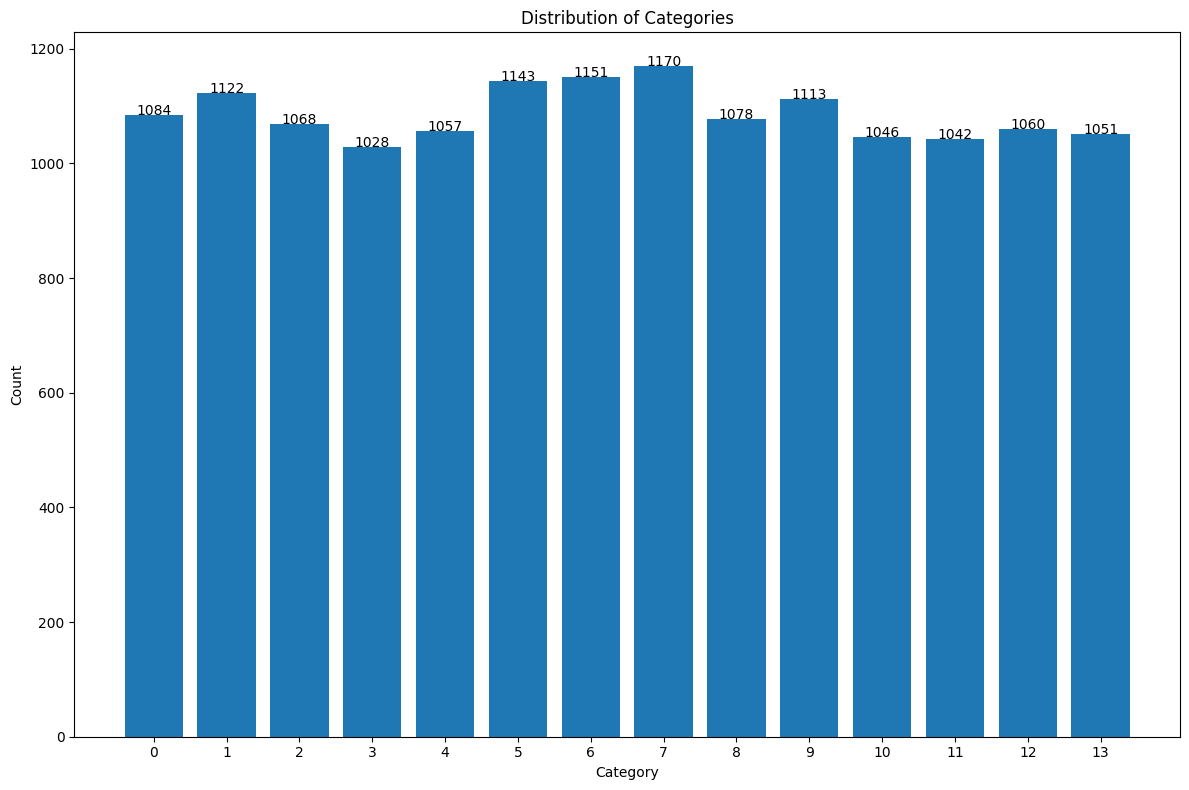

In [10]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [11]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=42
)

print(f'Number of training articles: {len(train_articles)}')
print(f'Number of validation articles: {len(val_articles)}')

Number of training articles: 12170
Number of validation articles: 3043


자유 (0): 7.26%
학사 (1): 7.48%
장학 · 행정 (2): 7.02%
학교생활 (3): 6.79%
수업 (4): 7.04%
수업/이과 (5): 7.48%
수업/문과 (6): 7.64%
캠퍼스 (7): 7.49%
취업 · 진로 (8): 7.02%
일상생활 (9): 7.41%
음식점 · 카페 (10): 6.78%
취미 · 여가 (11): 6.75%
인간관계 (12): 6.93%
병역 (13): 6.91%


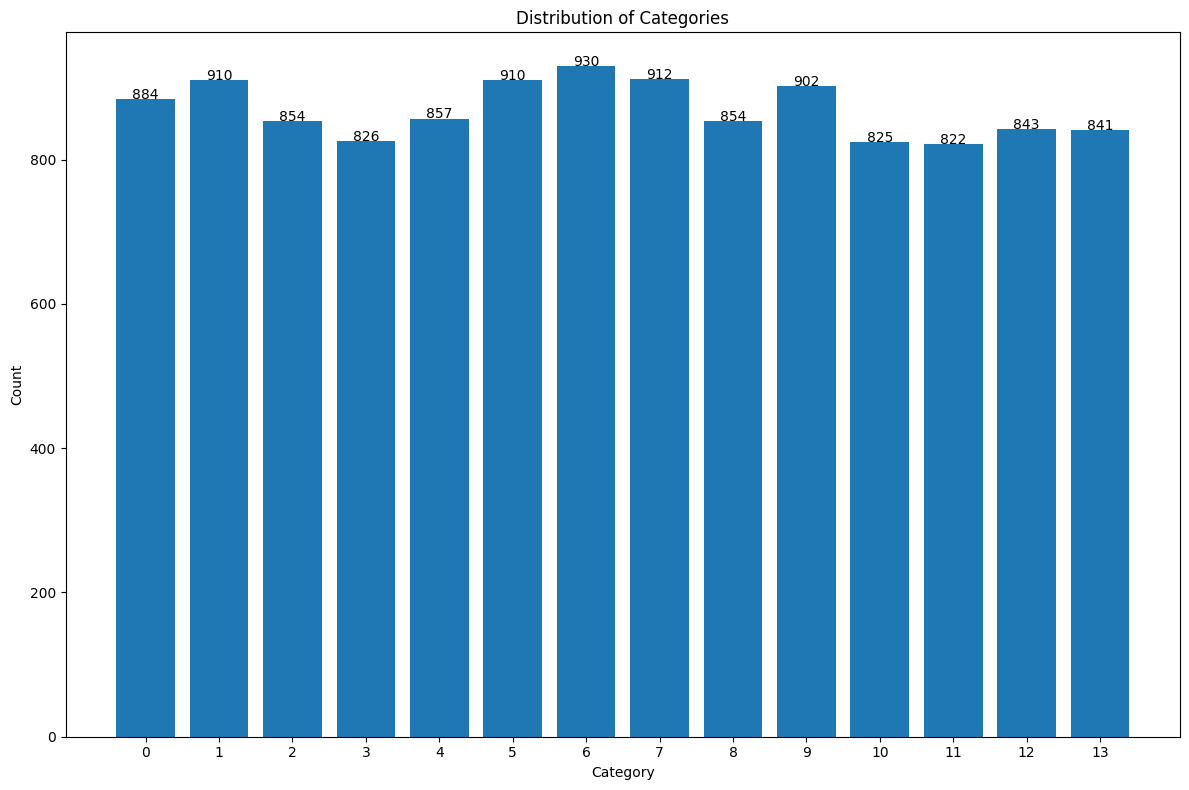

In [12]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

자유 (0): 6.57%
학사 (1): 6.97%
장학 · 행정 (2): 7.03%
학교생활 (3): 6.64%
수업 (4): 6.57%
수업/이과 (5): 7.66%
수업/문과 (6): 7.26%
캠퍼스 (7): 8.48%
취업 · 진로 (8): 7.36%
일상생활 (9): 6.93%
음식점 · 카페 (10): 7.26%
취미 · 여가 (11): 7.23%
인간관계 (12): 7.13%
병역 (13): 6.90%


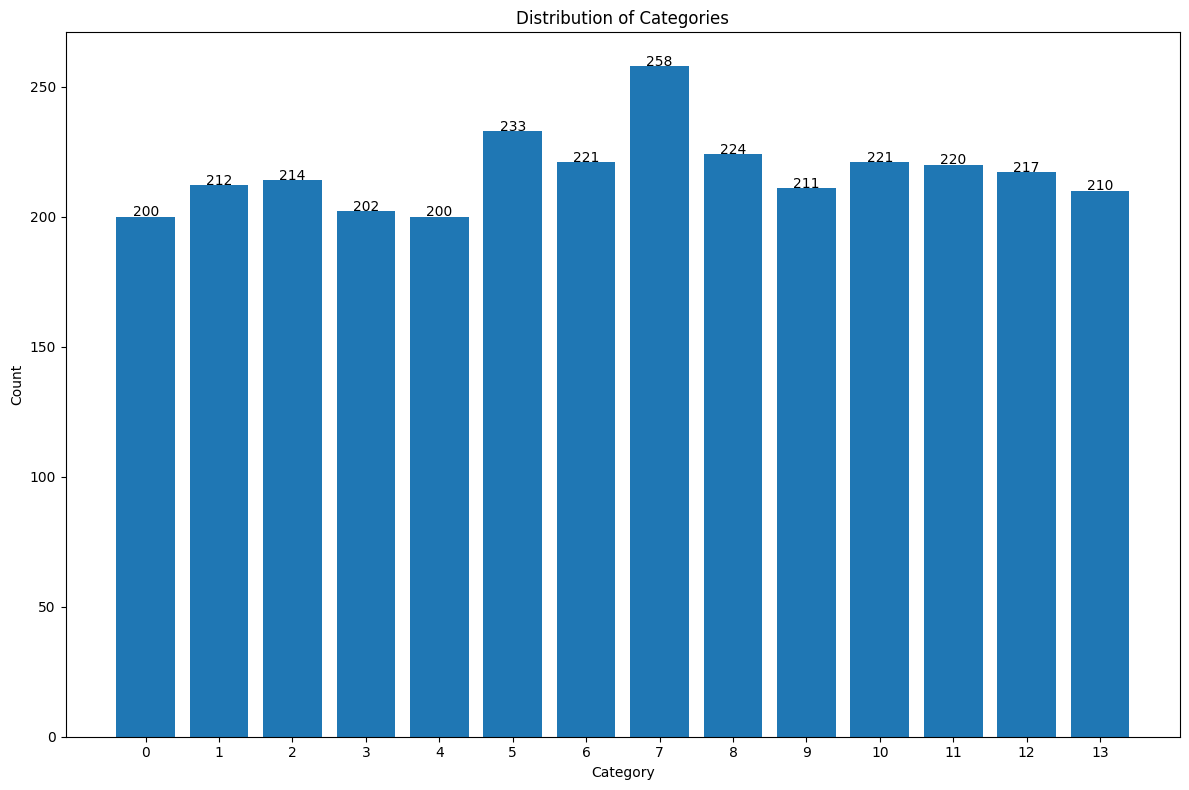

In [13]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [14]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: 어제 비마관 화장실에서 핸드폰 찾아주신분! 제가 경황이 없어서 감사하다고도 못 했네요. 정말 감사합니다!!!
Tokenized: ['어제', '비', '##마', '##관', '화장실', '##에서', '핸드폰', '찾아', '##주신', '##분', '!', '제가', '경', '##황', '##이', '없어서', '감사', '##하다고', '##도', '못', '했네요', '.', '정말', '감사합니다', '!', '!', '!']


In [15]:
# 모델 로드

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=NUM_LABELS)
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [16]:
# 텍스트 인코딩 및 데이터셋 생성

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_29608/2848816050.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_29608/2848816050.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_29608/2848816050.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_29608/2848816050.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

In [17]:
# 학습 전 초기화

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataset) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_accs = []
train_precs = []
train_recs = []
train_f_betas = []
train_losses = []

val_accs = []
val_precs = []
val_recs = []
val_f_betas = []
val_losses = []

In [18]:
# 평가 지표 계산 함수 정의

def calculate_metrics(true_labels, predicted_labels):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    rec = recall_score(true_labels, predicted_labels, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)
    f_beta = fbeta_score(true_labels, predicted_labels, beta=F_BETA, average=METRIC_AVERAGE, zero_division=METRIC_ZERO_DIVISION)

    return acc, prec, rec, f_beta

In [19]:
# 학습 시작

best_val_f_beta = 0.9
best_model_path = None

for epoch in range(EPOCHS):
    model.train()

    train_loss = 0.0
    train_predictions = []
    train_labels_epoch = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        train_predictions.extend(predictions.tolist())
        train_labels_epoch.extend(labels.tolist())

    train_acc, train_prec, train_rec, train_f_beta = calculate_metrics(train_labels_epoch, train_predictions)
    train_accs.append(train_acc)
    train_precs.append(train_prec)
    train_recs.append(train_rec)
    train_f_betas.append(train_f_beta)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()

    val_loss = 0.0
    val_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(predictions.tolist())

    val_acc, val_prec, val_rec, val_f_beta = calculate_metrics(val_labels, val_predictions)
    val_accs.append(val_acc)
    val_precs.append(val_prec)
    val_recs.append(val_rec)
    val_f_betas.append(val_f_beta)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Acc = {train_acc:.4f}, Train Prec = {train_prec:.4f}, Train Rec = {train_rec:.4f}, Train F-Beta = {train_f_beta:.4f}, Train Loss = {train_loss:.4f}')
    print(f'  Val Acc = {val_acc:.4f}, Val Prec = {val_prec:.4f}, Val Rec = {val_rec:.4f}, Val F-Beta = {val_f_beta:.4f}, Val Loss = {val_loss:.4f}')

    if val_f_beta > best_val_f_beta:
        best_val_f_beta = val_f_beta
        best_model_path = os.path.join(SAVE_PATH, f'model-epoch-{epoch + 1:02d}-{best_val_f_beta:.4f}')
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f'  Best model saved with {best_val_f_beta:.4f} F-beta score.')

print('Training finished.')

Epoch 1 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.80it/s]


Epoch 1:
  Train Acc = 0.8274, Train Prec = 0.8522, Train Rec = 0.8274, Train F-Beta = 0.8420, Train Loss = 0.9458
  Val Acc = 0.9901, Val Prec = 0.9902, Val Rec = 0.9901, Val F-Beta = 0.9902, Val Loss = 0.0840
  Best model saved with 0.9902 F-beta score.


Epoch 2 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.91it/s]


Epoch 2:
  Train Acc = 0.9890, Train Prec = 0.9890, Train Rec = 0.9890, Train F-Beta = 0.9890, Train Loss = 0.0784
  Val Acc = 0.9882, Val Prec = 0.9884, Val Rec = 0.9882, Val F-Beta = 0.9883, Val Loss = 0.0634


Epoch 3 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.91it/s]


Epoch 3:
  Train Acc = 0.9916, Train Prec = 0.9916, Train Rec = 0.9916, Train F-Beta = 0.9916, Train Loss = 0.0438
  Val Acc = 0.9895, Val Prec = 0.9895, Val Rec = 0.9895, Val F-Beta = 0.9895, Val Loss = 0.0523


Epoch 4 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.87it/s]


Epoch 4:
  Train Acc = 0.9947, Train Prec = 0.9947, Train Rec = 0.9947, Train F-Beta = 0.9947, Train Loss = 0.0288
  Val Acc = 0.9928, Val Prec = 0.9928, Val Rec = 0.9928, Val F-Beta = 0.9928, Val Loss = 0.0444
  Best model saved with 0.9928 F-beta score.


Epoch 5 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.62it/s]


Epoch 5:
  Train Acc = 0.9955, Train Prec = 0.9955, Train Rec = 0.9955, Train F-Beta = 0.9955, Train Loss = 0.0229
  Val Acc = 0.9832, Val Prec = 0.9837, Val Rec = 0.9832, Val F-Beta = 0.9835, Val Loss = 0.0722


Epoch 6 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.88it/s]


Epoch 6:
  Train Acc = 0.9976, Train Prec = 0.9976, Train Rec = 0.9976, Train F-Beta = 0.9976, Train Loss = 0.0136
  Val Acc = 0.9915, Val Prec = 0.9915, Val Rec = 0.9915, Val F-Beta = 0.9915, Val Loss = 0.0449


Epoch 7 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.90it/s]


Epoch 7:
  Train Acc = 0.9978, Train Prec = 0.9978, Train Rec = 0.9978, Train F-Beta = 0.9978, Train Loss = 0.0117
  Val Acc = 0.9921, Val Prec = 0.9922, Val Rec = 0.9921, Val F-Beta = 0.9921, Val Loss = 0.0469


Epoch 8 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.67it/s]


Epoch 8:
  Train Acc = 0.9965, Train Prec = 0.9966, Train Rec = 0.9965, Train F-Beta = 0.9966, Train Loss = 0.0164
  Val Acc = 0.9915, Val Prec = 0.9916, Val Rec = 0.9915, Val F-Beta = 0.9915, Val Loss = 0.0510


Epoch 9 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.90it/s]


Epoch 9:
  Train Acc = 0.9986, Train Prec = 0.9986, Train Rec = 0.9986, Train F-Beta = 0.9986, Train Loss = 0.0082
  Val Acc = 0.9928, Val Prec = 0.9928, Val Rec = 0.9928, Val F-Beta = 0.9928, Val Loss = 0.0491


Epoch 10 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.70it/s]


Epoch 10:
  Train Acc = 0.9978, Train Prec = 0.9978, Train Rec = 0.9978, Train F-Beta = 0.9978, Train Loss = 0.0101
  Val Acc = 0.9928, Val Prec = 0.9929, Val Rec = 0.9928, Val F-Beta = 0.9928, Val Loss = 0.0492
  Best model saved with 0.9928 F-beta score.


Epoch 11 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.81it/s]


Epoch 11:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0077
  Val Acc = 0.9878, Val Prec = 0.9882, Val Rec = 0.9878, Val F-Beta = 0.9880, Val Loss = 0.0789


Epoch 12 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.85it/s]


Epoch 12:
  Train Acc = 0.9970, Train Prec = 0.9970, Train Rec = 0.9970, Train F-Beta = 0.9970, Train Loss = 0.0137
  Val Acc = 0.9888, Val Prec = 0.9891, Val Rec = 0.9888, Val F-Beta = 0.9889, Val Loss = 0.0685


Epoch 13 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.89it/s]


Epoch 13:
  Train Acc = 0.9983, Train Prec = 0.9983, Train Rec = 0.9983, Train F-Beta = 0.9983, Train Loss = 0.0089
  Val Acc = 0.9911, Val Prec = 0.9912, Val Rec = 0.9911, Val F-Beta = 0.9912, Val Loss = 0.0631


Epoch 14 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.62it/s]


Epoch 14:
  Train Acc = 0.9984, Train Prec = 0.9984, Train Rec = 0.9984, Train F-Beta = 0.9984, Train Loss = 0.0094
  Val Acc = 0.9941, Val Prec = 0.9941, Val Rec = 0.9941, Val F-Beta = 0.9941, Val Loss = 0.0408
  Best model saved with 0.9941 F-beta score.


Epoch 15 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.64it/s]


Epoch 15:
  Train Acc = 0.9979, Train Prec = 0.9979, Train Rec = 0.9979, Train F-Beta = 0.9979, Train Loss = 0.0091
  Val Acc = 0.9924, Val Prec = 0.9925, Val Rec = 0.9924, Val F-Beta = 0.9924, Val Loss = 0.0560


Epoch 16 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.66it/s]


Epoch 16:
  Train Acc = 0.9975, Train Prec = 0.9975, Train Rec = 0.9975, Train F-Beta = 0.9975, Train Loss = 0.0105
  Val Acc = 0.9918, Val Prec = 0.9919, Val Rec = 0.9918, Val F-Beta = 0.9919, Val Loss = 0.0528


Epoch 17 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.64it/s]


Epoch 17:
  Train Acc = 0.9998, Train Prec = 0.9998, Train Rec = 0.9998, Train F-Beta = 0.9998, Train Loss = 0.0012
  Val Acc = 0.9931, Val Prec = 0.9931, Val Rec = 0.9931, Val F-Beta = 0.9931, Val Loss = 0.0524


Epoch 18 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.65it/s]


Epoch 18:
  Train Acc = 0.9999, Train Prec = 0.9999, Train Rec = 0.9999, Train F-Beta = 0.9999, Train Loss = 0.0005
  Val Acc = 0.9915, Val Prec = 0.9916, Val Rec = 0.9915, Val F-Beta = 0.9915, Val Loss = 0.0663


Epoch 19 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.68it/s]


Epoch 19:
  Train Acc = 0.9996, Train Prec = 0.9996, Train Rec = 0.9996, Train F-Beta = 0.9996, Train Loss = 0.0015
  Val Acc = 0.9869, Val Prec = 0.9873, Val Rec = 0.9869, Val F-Beta = 0.9871, Val Loss = 0.0883


Epoch 20 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.61it/s]


Epoch 20:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0079
  Val Acc = 0.9901, Val Prec = 0.9903, Val Rec = 0.9901, Val F-Beta = 0.9902, Val Loss = 0.0736


Epoch 21 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.65it/s]


Epoch 21:
  Train Acc = 0.9955, Train Prec = 0.9955, Train Rec = 0.9955, Train F-Beta = 0.9955, Train Loss = 0.0214
  Val Acc = 0.9911, Val Prec = 0.9912, Val Rec = 0.9911, Val F-Beta = 0.9912, Val Loss = 0.0659


Epoch 22 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.61it/s]


Epoch 22:
  Train Acc = 0.9984, Train Prec = 0.9984, Train Rec = 0.9984, Train F-Beta = 0.9984, Train Loss = 0.0064
  Val Acc = 0.9924, Val Prec = 0.9925, Val Rec = 0.9924, Val F-Beta = 0.9924, Val Loss = 0.0508


Epoch 23 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.69it/s]


Epoch 23:
  Train Acc = 0.9988, Train Prec = 0.9989, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0076
  Val Acc = 0.9924, Val Prec = 0.9925, Val Rec = 0.9924, Val F-Beta = 0.9925, Val Loss = 0.0533


Epoch 24 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.72it/s]


Epoch 24:
  Train Acc = 0.9985, Train Prec = 0.9985, Train Rec = 0.9985, Train F-Beta = 0.9985, Train Loss = 0.0057
  Val Acc = 0.9908, Val Prec = 0.9909, Val Rec = 0.9908, Val F-Beta = 0.9909, Val Loss = 0.0659


Epoch 25 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.69it/s]


Epoch 25:
  Train Acc = 0.9982, Train Prec = 0.9982, Train Rec = 0.9982, Train F-Beta = 0.9982, Train Loss = 0.0073
  Val Acc = 0.9898, Val Prec = 0.9899, Val Rec = 0.9898, Val F-Beta = 0.9899, Val Loss = 0.0652


Epoch 26 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.65it/s]


Epoch 26:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0058
  Val Acc = 0.9918, Val Prec = 0.9919, Val Rec = 0.9918, Val F-Beta = 0.9918, Val Loss = 0.0549


Epoch 27 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.68it/s]


Epoch 27:
  Train Acc = 0.9997, Train Prec = 0.9997, Train Rec = 0.9997, Train F-Beta = 0.9997, Train Loss = 0.0022
  Val Acc = 0.9928, Val Prec = 0.9929, Val Rec = 0.9928, Val F-Beta = 0.9928, Val Loss = 0.0506


Epoch 28 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.76it/s]


Epoch 28:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9924, Val Prec = 0.9925, Val Rec = 0.9924, Val F-Beta = 0.9925, Val Loss = 0.0577


Epoch 29 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.70it/s]


Epoch 29:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0002
  Val Acc = 0.9938, Val Prec = 0.9938, Val Rec = 0.9938, Val F-Beta = 0.9938, Val Loss = 0.0498


Epoch 30 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.68it/s]


Epoch 30:
  Train Acc = 1.0000, Train Prec = 1.0000, Train Rec = 1.0000, Train F-Beta = 1.0000, Train Loss = 0.0001
  Val Acc = 0.9934, Val Prec = 0.9935, Val Rec = 0.9934, Val F-Beta = 0.9935, Val Loss = 0.0497


Epoch 31 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.85it/s]


Epoch 31:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F-Beta = 0.9987, Train Loss = 0.0092
  Val Acc = 0.9921, Val Prec = 0.9922, Val Rec = 0.9921, Val F-Beta = 0.9921, Val Loss = 0.0512


Epoch 32 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.87it/s]


Epoch 32:
  Train Acc = 0.9988, Train Prec = 0.9988, Train Rec = 0.9988, Train F-Beta = 0.9988, Train Loss = 0.0059
  Val Acc = 0.9875, Val Prec = 0.9877, Val Rec = 0.9875, Val F-Beta = 0.9876, Val Loss = 0.0662


Epoch 33 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.81it/s]


Epoch 33:
  Train Acc = 0.9980, Train Prec = 0.9980, Train Rec = 0.9980, Train F-Beta = 0.9980, Train Loss = 0.0107
  Val Acc = 0.9928, Val Prec = 0.9928, Val Rec = 0.9928, Val F-Beta = 0.9928, Val Loss = 0.0537


Epoch 34 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.88it/s]


Epoch 34:
  Train Acc = 0.9993, Train Prec = 0.9993, Train Rec = 0.9993, Train F-Beta = 0.9993, Train Loss = 0.0023
  Val Acc = 0.9924, Val Prec = 0.9926, Val Rec = 0.9924, Val F-Beta = 0.9925, Val Loss = 0.0542


Epoch 35 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.87it/s]


Epoch 35:
  Train Acc = 0.9996, Train Prec = 0.9996, Train Rec = 0.9996, Train F-Beta = 0.9996, Train Loss = 0.0020
  Val Acc = 0.9934, Val Prec = 0.9935, Val Rec = 0.9934, Val F-Beta = 0.9935, Val Loss = 0.0514


Epoch 36 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.96it/s]


Epoch 36:
  Train Acc = 0.9990, Train Prec = 0.9990, Train Rec = 0.9990, Train F-Beta = 0.9990, Train Loss = 0.0053
  Val Acc = 0.9915, Val Prec = 0.9915, Val Rec = 0.9915, Val F-Beta = 0.9915, Val Loss = 0.0539


Epoch 37 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.86it/s]


Epoch 37:
  Train Acc = 0.9991, Train Prec = 0.9991, Train Rec = 0.9991, Train F-Beta = 0.9991, Train Loss = 0.0059
  Val Acc = 0.9852, Val Prec = 0.9856, Val Rec = 0.9852, Val F-Beta = 0.9854, Val Loss = 0.0843


Epoch 38 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.86it/s]


Epoch 38:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F-Beta = 0.9987, Train Loss = 0.0062
  Val Acc = 0.9915, Val Prec = 0.9915, Val Rec = 0.9915, Val F-Beta = 0.9915, Val Loss = 0.0552


Epoch 39 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.87it/s]


Epoch 39:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0034
  Val Acc = 0.9924, Val Prec = 0.9925, Val Rec = 0.9924, Val F-Beta = 0.9925, Val Loss = 0.0651


Epoch 40 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.87it/s]


Epoch 40:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0023
  Val Acc = 0.9921, Val Prec = 0.9922, Val Rec = 0.9921, Val F-Beta = 0.9921, Val Loss = 0.0654


Epoch 41 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.85it/s]


Epoch 41:
  Train Acc = 0.9994, Train Prec = 0.9994, Train Rec = 0.9994, Train F-Beta = 0.9994, Train Loss = 0.0050
  Val Acc = 0.9901, Val Prec = 0.9902, Val Rec = 0.9901, Val F-Beta = 0.9902, Val Loss = 0.0642


Epoch 42 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.86it/s]


Epoch 42:
  Train Acc = 0.9990, Train Prec = 0.9990, Train Rec = 0.9990, Train F-Beta = 0.9990, Train Loss = 0.0045
  Val Acc = 0.9924, Val Prec = 0.9925, Val Rec = 0.9924, Val F-Beta = 0.9925, Val Loss = 0.0502


Epoch 43 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.89it/s]


Epoch 43:
  Train Acc = 0.9998, Train Prec = 0.9998, Train Rec = 0.9998, Train F-Beta = 0.9998, Train Loss = 0.0012
  Val Acc = 0.9938, Val Prec = 0.9938, Val Rec = 0.9938, Val F-Beta = 0.9938, Val Loss = 0.0524


Epoch 44 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.88it/s]


Epoch 44:
  Train Acc = 0.9990, Train Prec = 0.9990, Train Rec = 0.9990, Train F-Beta = 0.9990, Train Loss = 0.0048
  Val Acc = 0.9924, Val Prec = 0.9925, Val Rec = 0.9924, Val F-Beta = 0.9925, Val Loss = 0.0647


Epoch 45 - Validation: 100%|██████████| 96/96 [00:09<00:00, 10.04it/s]


Epoch 45:
  Train Acc = 0.9987, Train Prec = 0.9987, Train Rec = 0.9987, Train F-Beta = 0.9987, Train Loss = 0.0061
  Val Acc = 0.9901, Val Prec = 0.9902, Val Rec = 0.9901, Val F-Beta = 0.9902, Val Loss = 0.0726


Epoch 46 - Validation: 100%|██████████| 96/96 [00:09<00:00, 10.01it/s]


Epoch 46:
  Train Acc = 0.9983, Train Prec = 0.9983, Train Rec = 0.9983, Train F-Beta = 0.9983, Train Loss = 0.0076
  Val Acc = 0.9898, Val Prec = 0.9899, Val Rec = 0.9898, Val F-Beta = 0.9898, Val Loss = 0.0694


Epoch 47 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.62it/s]


Epoch 47:
  Train Acc = 0.9993, Train Prec = 0.9993, Train Rec = 0.9993, Train F-Beta = 0.9993, Train Loss = 0.0040
  Val Acc = 0.9928, Val Prec = 0.9928, Val Rec = 0.9928, Val F-Beta = 0.9928, Val Loss = 0.0546


Epoch 48 - Validation: 100%|██████████| 96/96 [00:09<00:00,  9.75it/s]


Epoch 48:
  Train Acc = 0.9998, Train Prec = 0.9998, Train Rec = 0.9998, Train F-Beta = 0.9998, Train Loss = 0.0021
  Val Acc = 0.9918, Val Prec = 0.9919, Val Rec = 0.9918, Val F-Beta = 0.9918, Val Loss = 0.0577


Epoch 49 - Validation: 100%|██████████| 96/96 [00:10<00:00,  9.59it/s]


Epoch 49:
  Train Acc = 0.9996, Train Prec = 0.9996, Train Rec = 0.9996, Train F-Beta = 0.9996, Train Loss = 0.0020
  Val Acc = 0.9924, Val Prec = 0.9925, Val Rec = 0.9924, Val F-Beta = 0.9925, Val Loss = 0.0533


Epoch 50 - Validation: 100%|██████████| 96/96 [00:10<00:00,  9.58it/s]

Epoch 50:
  Train Acc = 0.9998, Train Prec = 0.9998, Train Rec = 0.9998, Train F-Beta = 0.9998, Train Loss = 0.0005
  Val Acc = 0.9931, Val Prec = 0.9931, Val Rec = 0.9931, Val F-Beta = 0.9931, Val Loss = 0.0614
Training finished.


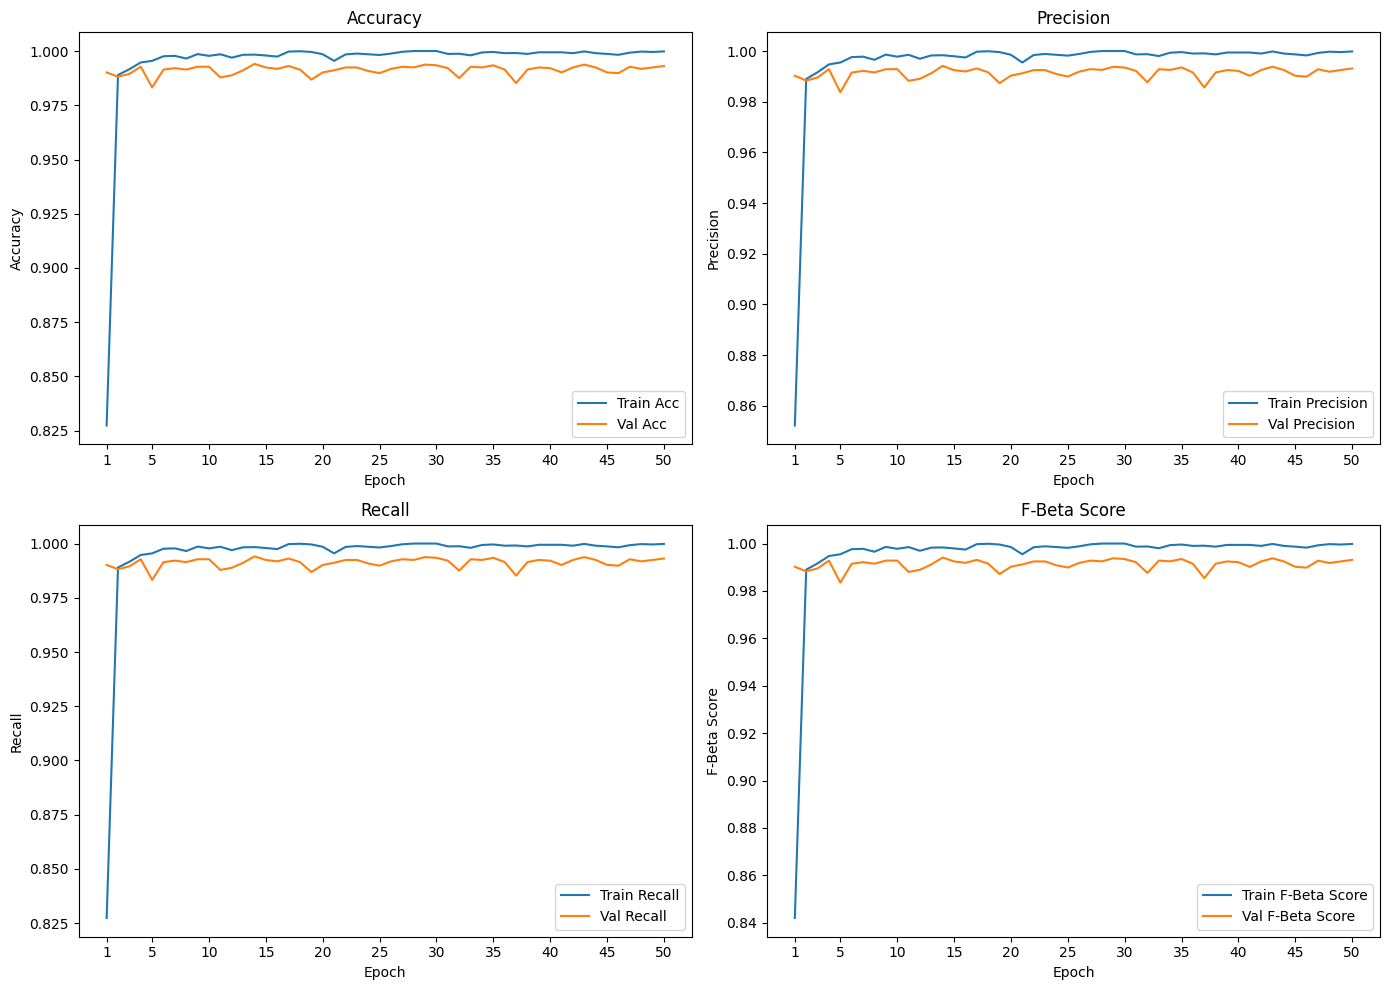

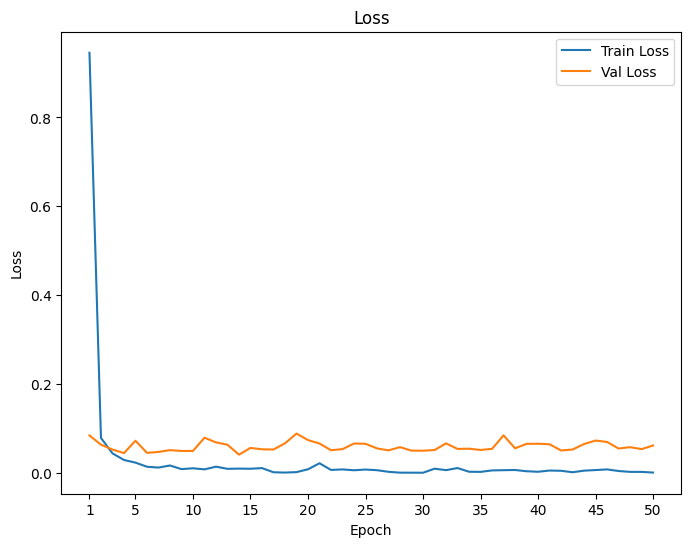

In [20]:
# 학습 결과 시각화

if EPOCHS <= 20:
    step = 1
elif EPOCHS <= 50:
    step = 5
elif EPOCHS <= 100:
    step = 10
else:
    step = 20

epochs = range(1, EPOCHS + 1)
tick_marks = [1] + list(range(step, EPOCHS + 1, step))

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_precs, label='Train Precision')
plt.plot(epochs, val_precs, label='Val Precision')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Precision')
plt.legend()
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.plot(epochs, train_recs, label='Train Recall')
plt.plot(epochs, val_recs, label='Val Recall')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Recall')
plt.legend()
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(epochs, train_f_betas, label='Train F-Beta Score')
plt.plot(epochs, val_f_betas, label='Val F-Beta Score')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('F-Beta Score')
plt.legend()
plt.title('F-Beta Score')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.xticks(tick_marks)
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [21]:
# 평가

print(f'Best model path: {best_model_path}')
print()

model = AutoModelForSequenceClassification.from_pretrained(best_model_path, num_labels=NUM_LABELS)
model.to(device)

predictions = [
    # 자유
    'ㅋㅋㅋㅋㅋㅋㅋㅋ 이거 존나 웃기네',
    '아무 주제나 올려도 되는 건가요? 규칙 같은 건 없어?',
    '자유 게시판이랑 일반 게시판이랑 뭐가 다른거야?',
    '학교 관련된 거 말고도 여기다 글 써도 돼?',
    '자유 주제로 올릴 만한 게시글 추천해 줄 수 있어?',

    # 학사
    '내일까지 드랍 가능한가요? 아직 고민 중인데 말이죠.',
    '학점 이렇게 가져가도 졸업할 수 있나요? 상담 좀 해주세요.',
    '복수전공 하고 싶은데 어떻게 신청해야 하죠?',
    '이번 학기 시험 기간이 언제인지 알려주세요.',
    '학사 경고 받으면 어떻게 되나요? 대책 좀 세워주세요.',

    # 장학 · 행정
    '장학금 신청은 언제까지인가요? 놓치기 싫어서요.',
    '학자금 대출 신청 방법 좀 알려주세요. 처음이라서 모르겠네요.',
    '증명서 발급은 어디서 하나요? 빨리 뽑아야 하는데.',
    '교환학생 프로그램 정보 좀 주세요. 어디서 볼 수 있나요?',
    '학적 변경은 어떻게 하는 건가요? 절차를 몰라서요.',

    # 학교생활
    '동아리 언제 가입할 수 있어요? 종류도 많던데 추천 좀.',
    '학교 축제 언제 열리나요? 라인업 알려주세요.',
    '대학교 내에서 봉사활동 할 수 있는 곳 있나요?',
    '학생회 행사 계획이 궁금해요. 어디서 정보를 얻을 수 있죠?',
    '경험 공유하고 싶은데, 여기다 써도 되나요?',

    # 수업
    '이번 학기 추천 교양 과목 있어요? 뭘 들을지 고민 중입니다.',
    '교수님 평가 어디서 볼 수 있나요? 들을까 말까 고민 중이에요.',
    '과제 제출 기한 연장 가능한가요? 이번 주 바빠서요.',
    '시험 범위가 어디까지인가요? 교수님이 안 알려주셔서요.',
    '수업 시간에 늦게 들어가도 되나요? 늦잠 잤어요.',

    # 수업/이과
    '물리학 수업 어떻게 생각해? 괜찮은 교수님 있으면 소개해줘.',
    '이과 수업 중에서 데이터 사이언스 강의 들어본 사람?',
    '화학 실험 수업 때 필요한 준비물이 뭐가 있어?',
    '공학과에서 꼭 들어야 할 필수 과목 뭐 있어?',
    '이과 수업 중에서 졸업 후 도움 많이 됐던 거 추천해줘.',

    # 수업/문과
    '문과 수업 중에서 역사 관련 수업 추천해주세요.',
    '경제학 기초부터 배울 수 있는 수업 있을까?',
    '문과 중에서도 문학 수업 좀 알려주세요. 분위기가 궁금해.',
    '법학 수업 듣는 거 어때? 실제로 도움 되는지 궁금해.',
    '사회학 수업 중에 어떤 걸 들으면 좋을지 조언 부탁해.',

    # 캠퍼스
    '캠퍼스 내에 숨겨진 맛집 있으면 공유해줘!',
    '학교 주변에 저렴한 주차장 아는 곳 있어?',
    '캠퍼스 안에서 가장 조용한 공부할 장소 추천해주세요.',
    '기숙사 생활하면서 알게 된 꿀팁 있어?',
    '학교에서 제공하는 심리 상담 서비스가 어떤 것들이 있나요?',

    # 취업 · 진로
    '취업 준비하면서 가장 중요하게 생각해야 할 것 뭐라고 생각해?',
    '인턴 경험이 취업에 도움이 많이 되나요? 경험 공유 부탁해.',
    '취업 스터디 그룹 있으면 소개 좀 해줘. 참여하고 싶어.',
    '대외활동하면서 느낀 점이나 팁 있으면 공유해줘.',
    '자격증 필요성에 대해 어떻게 생각해? 진짜 필요한 건지 궁금해.',

    # 일상생활
    '아르바이트 하면서 학교 생활 병행하는 팁 있어?',
    '건강 관리 어떻게 하고 있어? 학교 생활하면서 힘든데.',
    '자취하는데 요리 쉽고 간단한 거 추천해줘.',
    '일상생활에서 스트레스 관리하는 방법 공유해줘.',
    '대학 생활하면서 가장 필요한 물건이 뭐라고 생각해?',

    # 음식점 · 카페
    '캠퍼스 내에서 가장 맛있는 커피 파는 카페 어디야?',
    '학교 근처 맛집 리스트 좀 알려줄 수 있어?',
    '점심 뭐 먹을지 추천해줄 수 있어? 학교 주변에서.',
    '카페에서 공부하기 좋은 자리 어디에 있는지 알려줘.',
    '새로 생긴 학교 근처 배달 음식점 어떤 게 있어?',

    # 취미 · 여가
    '주말에 가볼만한 근처 여행지 추천해줘.',
    '게임 좋아하는 사람들 모여서 같이 할래? 같이 게임하자!',
    '영화 보러 갈 사람 구해. 같이 볼 사람?',
    '운동 시작하려고 하는데 좋은 운동 추천해줘.',
    '요리 배우고 싶은데 좋은 클래스 있으면 추천해줘.',

    # 인간관계
    '친구 사귀기 어려운 거 같아. 대학교에서 친구 어떻게 사귀어?',
    '선후배 관계에서 유의해야 할 점이 뭐가 있을까?',
    '연애하고 싶은데 대학에서 어떻게 시작해야 할지 모르겠어.',
    '성격 개선하고 싶은데, 어떻게 시작하는 게 좋을까?',
    '대인관계에서 겪는 어려움 어떻게 해결하고 있어?',

    # 병역
    '군대 가기 전에 준비할 것들 리스트 좀 주세요.',
    '입대 후에 학교는 어떻게 되나요? 복학은 어떻게 하죠?',
    '군 생활에서 꼭 알아야 할 팁 있으면 공유해주세요.',
    '예비군 훈련은 어떻게 진행되나요? 준비물은 뭐가 필요하죠?',
    '대체 복무 관련해서 궁금한 점이 많습니다. 자세히 설명해주실 수 있나요?'
]

encodings = tokenizer(
    predictions,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
input_ids = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1).tolist()

for text, label, probs in zip(predictions, predicted_labels, probabilities.tolist()):
    predicted_category = CATEGORIES[label]
    probs_formatted = [f"{prob:.4f}" for prob in probs]
    print(f'텍스트: {text}')
    print(f'예측: {predicted_category} {probs_formatted}')
    print()

Best model path: ./model-epoch-14-0.9941

텍스트: ㅋㅋㅋㅋㅋㅋㅋㅋ 이거 존나 웃기네
예측: 자유 ['0.9993', '0.0000', '0.0000', '0.0001', '0.0001', '0.0000', '0.0000', '0.0001', '0.0000', '0.0000', '0.0000', '0.0001', '0.0000', '0.0000']

텍스트: 아무 주제나 올려도 되는 건가요? 규칙 같은 건 없어?
예측: 캠퍼스 ['0.0026', '0.1012', '0.1149', '0.1091', '0.0149', '0.0740', '0.0074', '0.5263', '0.0255', '0.0083', '0.0011', '0.0032', '0.0054', '0.0061']

텍스트: 자유 게시판이랑 일반 게시판이랑 뭐가 다른거야?
예측: 캠퍼스 ['0.0015', '0.0004', '0.0031', '0.1570', '0.0008', '0.0007', '0.0009', '0.8186', '0.0072', '0.0019', '0.0005', '0.0052', '0.0007', '0.0016']

텍스트: 학교 관련된 거 말고도 여기다 글 써도 돼?
예측: 장학 · 행정 ['0.0044', '0.0185', '0.3876', '0.0301', '0.0234', '0.0769', '0.0593', '0.0860', '0.2914', '0.0055', '0.0017', '0.0029', '0.0028', '0.0095']

텍스트: 자유 주제로 올릴 만한 게시글 추천해 줄 수 있어?
예측: 캠퍼스 ['0.0048', '0.0379', '0.0388', '0.0358', '0.0013', '0.0315', '0.0916', '0.5566', '0.0214', '0.0410', '0.0034', '0.1287', '0.0014', '0.0059']

텍스트: 내일까지 드랍 가능한가요? 아직 고민 중인데 말이죠.
예측: 학사 ['0.000